# Data cleaning

Preprocess missing values (N/A)

In [1]:
import numpy as np
import pandas as pd
import re

import matplotlib.pyplot as plt

pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)

In [2]:
def load_by_chunks(path: str, chunk_size: int = 50_000) -> pd.DataFrame:
    chunks = pd.read_csv(path, chunksize=chunk_size)
    return pd.concat(chunks, ignore_index=True)

X_train = load_by_chunks('X_train_Hi5.csv')
X_test = load_by_chunks('X_test_Hi5.csv')

/tmp/ipykernel_115322/2956189229.py:3: DtypeWarning: Columns (1,5) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.concat(chunks, ignore_index=True)
/tmp/ipykernel_115322/2956189229.py:3: DtypeWarning: Columns (130,133,134) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.concat(chunks, ignore_index=True)
/tmp/ipykernel_115322/2956189229.py:3: DtypeWarning: Columns (130,133,134) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.concat(chunks, ignore_index=True)
/tmp/ipykernel_115322/2956189229.py:3: DtypeWarning: Columns (1,5,130,133,134) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.concat(chunks, ignore_index=True)
/tmp/ipykernel_115322/2956189229.py:3: DtypeWarning: Columns (1,5) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.concat(chunks, ignore_index=True)
/tmp/ipykernel_115322/2956189229.py:3

## Remove columns with too many missing values

In [3]:
def columns_with_missing_values(df: pd.DataFrame) -> pd.Series:
    """
    Returns the columns left with missing values to handle individually,
    by replacing with means or something else.
    """
    missing_values = df.isna().sum()
    return missing_values[missing_values > 0] / len(df)

In [4]:
columns_with_missing_values(X_test)

piezo_station_investigation_depth       0.063568
piezo_station_pe_label                  0.079281
piezo_station_bdlisa_codes              0.048592
piezo_producer_code                     0.032586
piezo_producer_name                     0.032586
piezo_measure_nature_code               0.032997
piezo_measure_nature_name               0.032997
meteo_rain_height                       0.011538
meteo_DRR                               0.885874
meteo_temperature_min                   0.031750
meteo_time_tn                           0.045138
meteo_temperature_max                   0.031772
meteo_time_tx                           0.044893
meteo_temperature_avg                   0.041766
meteo_temperature_avg_threshold         0.031816
meteo_temperature_min_ground            0.734729
meteo_temperature_min_50cm              0.842638
meteo_frost_duration                    0.089945
meteo_amplitude_tn_tx                   0.031816
meteo_temperature_avg_tntm              0.031816
meteo_pressure_avg  

In [5]:
def columns_to_drop(df: pd.DataFrame, threshold=0.2):
    to_drop = df.isna().sum() / len(df) > threshold
    return [col for col in df.columns if to_drop[col]]

In [6]:
def drop_columns(df: pd.DataFrame, threshold=0.2, inplace=False):
    """
    Drop columns with a fraction of more than `threshold` missing values.
    """
    threshold = int((1.0 - threshold) * len(df))
    return df.dropna(axis=1, thresh=threshold, inplace=inplace)

In [7]:
cols_to_drop = list(set(columns_to_drop(X_train) + columns_to_drop(X_test)))
X_train.drop(columns=cols_to_drop, inplace=True)
X_test.drop(columns=cols_to_drop, inplace=True)
columns_with_missing_values(X_train)

piezo_station_investigation_depth    0.063266
piezo_station_pe_label               0.081211
piezo_station_bdlisa_codes           0.049940
piezo_producer_code                  0.051521
piezo_producer_name                  0.051521
piezo_measure_nature_code            0.039708
piezo_measure_nature_name            0.039708
meteo_rain_height                    0.009001
meteo_temperature_min                0.085004
meteo_time_tn                        0.120212
meteo_temperature_max                0.083787
meteo_time_tx                        0.120009
meteo_temperature_avg                0.117295
meteo_temperature_avg_threshold      0.085093
meteo_frost_duration                 0.168575
meteo_amplitude_tn_tx                0.085093
meteo_temperature_avg_tntm           0.085093
meteo_evapotranspiration_grid        0.115353
insee_%_agri                         0.009476
insee_pop_commune                    0.009476
insee_med_living_level               0.009476
insee_%_ind                       

In [8]:
def preprocess_prelevement(df: pd.DataFrame):
    """
    For prelevement data, only keep the max of the 0, 1 and 2 prelevement data
    by modifying the dataframe in-place.
    """
    # Define prelevement-related columns
    prelev_columns = {
        "structure": ["prelev_structure_code_0", "prelev_structure_code_1", "prelev_structure_code_2"],
        "volume": ["prelev_volume_0", "prelev_volume_1", "prelev_volume_2"],
        "usage_label": ["prelev_usage_label_0", "prelev_usage_label_1", "prelev_usage_label_2"],
        "volume_mode": ["prelev_volume_obtention_mode_label_0", "prelev_volume_obtention_mode_label_1", "prelev_volume_obtention_mode_label_2"],
        "longitude": ["prelev_longitude_0", "prelev_longitude_1", "prelev_longitude_2"],
        "latitude": ["prelev_latitude_0", "prelev_latitude_1", "prelev_latitude_2"],
        "commune_code": ["prelev_commune_code_insee_0", "prelev_commune_code_insee_1", "prelev_commune_code_insee_2"]
    }

    # Step 1: Get the index of the maximum volume for each row
    try:
        max_volume_index = df[prelev_columns["volume"]].values.argmax(axis=1)
    except KeyError:
        pass # all three columns have been dropped already
    # Step 2: For each column group, select the corresponding value based on max_volume_index
    for key, cols in prelev_columns.items():
        try:
            # Convert columns to a NumPy array
            data_array = df[cols].values

            # Use advanced indexing to select the appropriate value for each row
            df[f"{key}_max"] = data_array[np.arange(len(df)), max_volume_index]
        except KeyError:
            pass # all three columns have been dropped already

    # Step 3: Drop the old columns
    columns_to_drop = [col for cols in prelev_columns.values() for col in cols if col in df.columns]
    df.drop(columns=columns_to_drop, inplace=True)

In [9]:
preprocess_prelevement(X_train)
preprocess_prelevement(X_test)

## Remove rows with too many missing values

In [10]:
def drop_rows(df: pd.DataFrame, threshold=5, inplace=False):
    """
    Drop rows with more than `threshold` missing values.
    """
    threshold = len(df.columns) - threshold
    return df.dropna(axis=0, thresh=threshold, inplace=inplace)

We only drop rows for `X_train` since we actually need to predict for each row of `X_test`.

In [11]:
drop_rows(X_train, inplace=True)

## Visualize missing values

We plot a matrix of N/A values in the tabular dataset.

In [12]:
def plot_missing_values(df: pd.DataFrame):
    # Binary matrix (1 if NaN, 0 otherwise)
    nan_matrix2 = df.isna()
    plt.figure(figsize=(10, 8))  # Adjust figure size according to the dataset
    plt.imshow(nan_matrix2, cmap='Greys', aspect='auto')  # Black = NaN
    plt.colorbar(label='Presence of NaNs (1 = NaN, 0 = Non)')
    plt.title('Map of missing values (NaN)')
    plt.xlabel('Columns')
    plt.ylabel('Rows')
    plt.show()

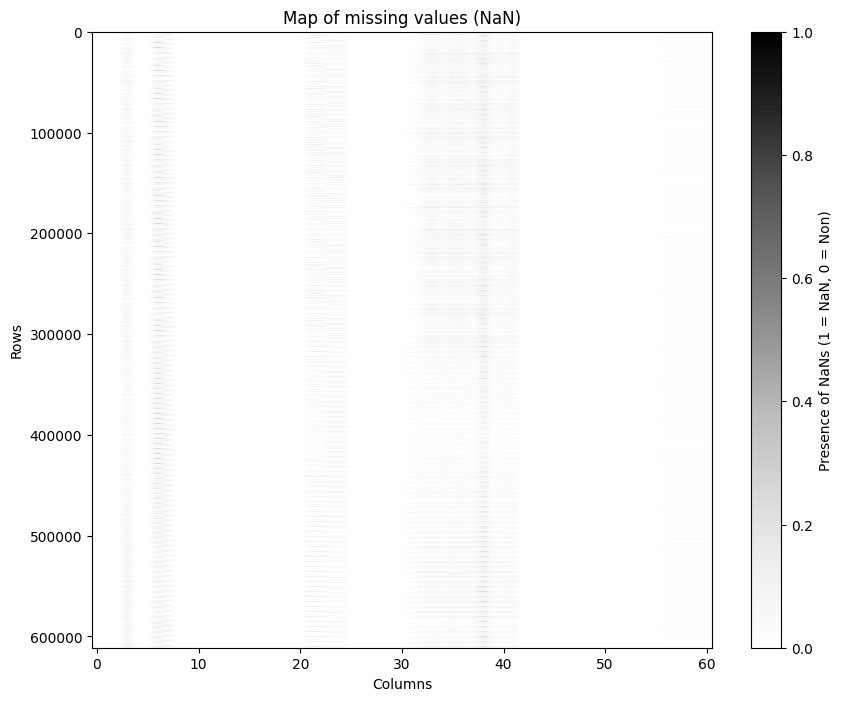

In [13]:
plot_missing_values(X_test)

In [14]:
print(columns_with_missing_values(X_test))

piezo_station_investigation_depth    0.063568
piezo_station_pe_label               0.079281
piezo_station_bdlisa_codes           0.048592
piezo_producer_code                  0.032586
piezo_producer_name                  0.032586
piezo_measure_nature_code            0.032997
piezo_measure_nature_name            0.032997
meteo_rain_height                    0.011538
meteo_temperature_min                0.031750
meteo_time_tn                        0.045138
meteo_temperature_max                0.031772
meteo_time_tx                        0.044893
meteo_temperature_avg                0.041766
meteo_temperature_avg_threshold      0.031816
meteo_frost_duration                 0.089945
meteo_amplitude_tn_tx                0.031816
meteo_temperature_avg_tntm           0.031816
meteo_evapotranspiration_grid        0.045606
insee_%_agri                         0.009313
insee_pop_commune                    0.009313
insee_med_living_level               0.009313
insee_%_ind                       

In [15]:
def fill_nan_with_monthly_department_avg(df, columns_to_fill):
    """
    Fills NaN values in specified columns with the average of other stations
    in the same month and department.
    
    Parameters:
    - df: pandas DataFrame
    - columns_to_fill: list of column names to fill missing values
    
    Returns:
    - DataFrame with NaN values filled
    """
    # Ensure the date column is in datetime format
    df['piezo_measurement_date'] = pd.to_datetime(df['piezo_measurement_date'])
    
    # Extract 'month' from the date if not already present
    if 'month' not in df.columns:
        df['month'] = df['piezo_measurement_date'].dt.month

    # Group by department and month
    grouped = df.groupby(['piezo_station_department_code', 'month'])

    # Iterate over the specified columns to fill
    for col in columns_to_fill:
        # Compute monthly department averages
        avg_values = grouped[col].transform(lambda x: x.mean(skipna=True))
        
        # Fill NaN values with the computed averages
        df[col] = df[col].fillna(avg_values)

    return df

In [16]:
# Usage Example
columns_to_fill = ['piezo_station_investigation_depth', 'piezo_producer_code', 'meteo_rain_height', 'meteo_time_tn', 'meteo_temperature_max', 'meteo_time_tx', 'meteo_temperature_avg', 'meteo_temperature_avg_threshold', 'meteo_frost_duration', 'meteo_amplitude_tn_tx', 'meteo_temperature_avg_tntm', 'meteo_evapotranspiration_grid', 'insee_pop_commune']
X_train = fill_nan_with_monthly_department_avg(X_train, columns_to_fill)
X_test = fill_nan_with_monthly_department_avg(X_test, columns_to_fill)

In [17]:
columns_object_to_fill = ['piezo_station_pe_label', 'piezo_station_bdlisa_codes', 'piezo_producer_name', 'piezo_measure_nature_code', 'piezo_measure_nature_name', 'insee_%_agri', 'insee_med_living_level', 'insee_%_ind', 'insee_%_const']

def fill_nan_object_with_most_frequent(df, columns_to_fill):
    for var in columns_to_fill:
        most_frequent_value = df[var].mode()[0]
        df[var].fillna(most_frequent_value, inplace=True)
    return df

X_train = fill_nan_object_with_most_frequent(X_train, columns_object_to_fill)        
X_test = fill_nan_object_with_most_frequent(X_test, columns_object_to_fill)

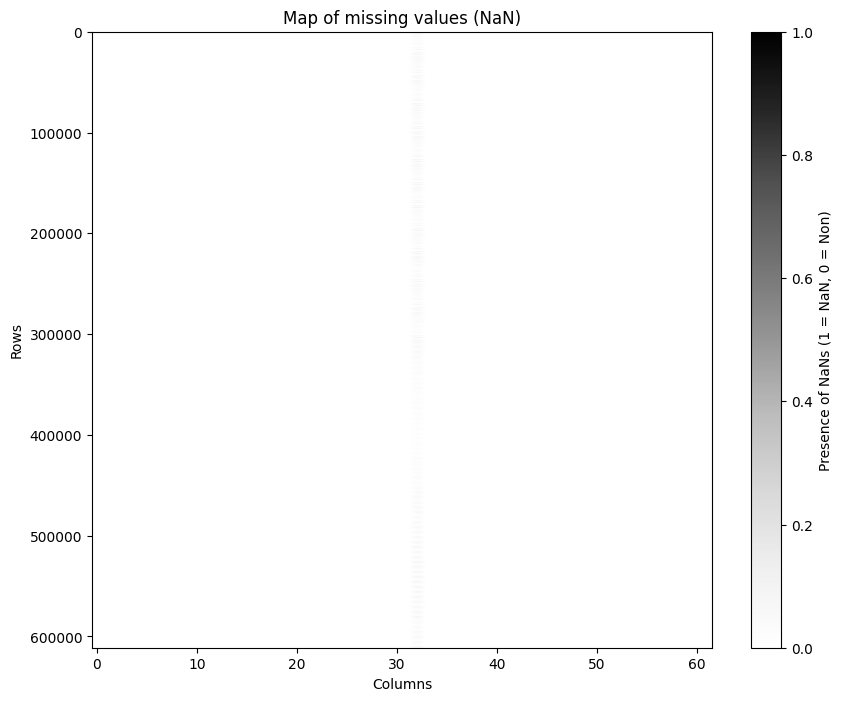

In [18]:
plot_missing_values(X_test)

## Save the clean data

In [19]:
X_train.to_csv('X_train_clean.csv')
X_test.to_csv('X_test_clean.csv')